# Capital Ratios
## 1. Market and Book Capital ratios

In [1]:
import pandas as pd
import numpy as np

In [2]:
ticks = pd.read_csv ('../data/manual/ticks.csv', sep="|")
ticks['gvkey'] = ticks['gvkey'].fillna(0.0).astype(int)
ticks['Permco'] = ticks['Permco'].fillna(0.0).astype(int)
ticks

,Primary Dealer,Holding Company,Ticker,Start Date,End Date,Permco,gvkey
0,ABN AMRO INCORPORATED,NaN,ABN,9/29/1998,9/15/2006,31989,15504
1,"AUBREY G. LANSTON & CO., INC.",Citigroup Inc.,C (NYSE),5/19/1960,4/17/2000,20483,3243
2,BA Securities,Bank of America Corporation,BAC (NYSE),4/18/1994,9/30/1997,437,7647
3,Banc One,JPMorgan Chase & Co. (Acquired by JPMorgan Chase),JPM (NYSE),4/1/1999,8/1/2004,20436,2968
4,Bank of America,Bank of America Corporation,BAC (NYSE),11/17/1971,4/15/1994,437,7647
...,...,...,...,...,...,...,...
106,"WERTHEIM SCHRODER & CO., INC.",Schroder Wertheim & Co. Inc.,NaN,6/24/1988,11/8/1990,0,0
107,WESTPAC POLLOCK GOV'T SECURITIES INC,Westpac Banking Corporation,WBK (NYSE),2/4/1987,6/27/1990,22027,15362
108,"WHITE, WELD & CO INC.","Merrill Lynch & Co., Inc.",NaN,2/26/1976,4/18/1978,21190,7267
109,"YAMAICHI INT'L (AMERICA), INC.",Yamaichi Securities Company Limited,NaN,9/29/1988,12/4/1997,0,0


In [3]:
import pandas as pd
import wrds
import config
from datetime import datetime

db = wrds.Connection(wrds_username=config.WRDS_USERNAME)

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [4]:
# Function to convert date to quarter format 'YYYYQ#'
def date_to_quarter(date):
    year = date.year
    quarter = (date.month - 1) // 3 + 1
    return f"{year}Q{quarter}"

# Function to convert quarter 'YYYYQ#' to date format
def quarter_to_date(quarter):
    year = int(quarter[:4])
    quarter = int(quarter[-1])
    month = quarter * 3 
    return datetime(year, month, 1) + pd.DateOffset(months=1) - pd.DateOffset(days=1)


In [5]:
def fetch_financial_data_quarterly(pgvkey, start_date, end_date):
    """
    Fetch financial data for a given ticker and date range from the CCM database in WRDS.
    
    :param gvkey: The gvkey symbol for the company.
    :param start_date: The start date for the data in YYYY-MM-DD format.
    :param end_date: The end date for the data in YYYY-MM-DD format or 'Current'.
    :return: A DataFrame containing the financial data.
    """
    if not gvkey:  # Skip if no ticker is available
        return pd.DataFrame()
    
    # Convert 'Current' to today's date if necessary
    if end_date == 'Current':
        end_date = datetime.today().strftime('%Y-%m-%d')
    
    # Convert start and end dates to datetime objects
    start_date_dt = pd.to_datetime(start_date)
    end_date_dt = pd.to_datetime(end_date)
    
    # Format start and end quarters
    start_qtr = date_to_quarter(start_date_dt)
    end_qtr = date_to_quarter(end_date_dt)

    query = f"""
    SELECT datafqtr, atq AS total_assets, ltq AS book_debt, 
            COALESCE(teqq, ceqq + COALESCE(pstkq, 0) + COALESCE(mibnq, 0)) AS book_equity, 
            cshoq*prccq AS market_equity, gvkey, conm
    FROM comp.fundq as cst
    WHERE cst.gvkey = '{str(pgvkey).zfill(6)}'
    AND cst.datafqtr BETWEEN '{start_qtr}' AND '{end_qtr}'
    AND indfmt='INDL'
    AND datafmt='STD'
    AND popsrc='D'
    AND consol='C'
    """
    data = db.raw_sql(query)
    return data

Get all data for primary dealers

In [6]:
empty_tickers = []
prim_dealers = pd.DataFrame()

# Iterate over DataFrame rows and fetch data for each ticker
for index, row in ticks.iterrows():
    gvkey = row['gvkey']
    start_date = row['Start Date']
    end_date = row['End Date']     # Formatting date for the query
    
    # Fetch financial data for the ticker if available
    new_data = fetch_financial_data_quarterly(gvkey, start_date, end_date)
    if isinstance(new_data, tuple):
        empty_tickers.append({row['Ticker']:gvkey})
    else:
        prim_dealers = pd.concat([new_data, prim_dealers], axis=0)
print(empty_tickers)

/var/folders/hk/t7fnwnf568g5fqkjmc9d2vbr0000gn/T/ipykernel_91664/2578673110.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  prim_dealers = pd.concat([new_data, prim_dealers], axis=0)
/var/folders/hk/t7fnwnf568g5fqkjmc9d2vbr0000gn/T/ipykernel_91664/2578673110.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  prim_dealers = pd.concat([new_data, prim_dealers], axis=0)
/var/folders/hk/t7fnwnf568g5fqkjmc9d2vbr0000gn/T/ipykernel_91664/2578673110.py:15: FutureWarning: The behavior of DataFrame 

[]


Get data from all firms in Compustat

In [7]:
prim_dealers = prim_dealers.drop_duplicates()
prim_dealers['datafqtr'] = prim_dealers['datafqtr'].apply(quarter_to_date)
prim_dealers

,datafqtr,total_assets,book_debt,book_equity,market_equity,gvkey,conm
0,1993-09-30,53855.500,50158.000,3697.500,8450.487500,008007,WELLS FARGO & CO
1,1993-12-31,54665.000,50904.098,3760.900,7490.413125,008007,WELLS FARGO & CO
2,1994-03-31,55328.199,51474.898,3853.300,7518.237500,008007,WELLS FARGO & CO
3,1994-06-30,55756.797,51920.199,3836.600,8241.314125,008007,WELLS FARGO & CO
4,1994-09-30,56565.398,52741.098,3824.300,7746.898500,008007,WELLS FARGO & CO
...,...,...,...,...,...,...,...
28,2005-09-30,1084338.560,1056726.945,25221.719,45031.200000,015504,ABN-AMRO HOLDINGS NV
29,2005-12-31,1043048.097,1014447.298,26314.109,49088.828800,015504,ABN-AMRO HOLDINGS NV
30,2006-03-31,1183661.751,1152907.595,28293.581,56132.568000,015504,ABN-AMRO HOLDINGS NV
31,2006-06-30,1260032.402,1228193.523,29329.083,51765.120000,015504,ABN-AMRO HOLDINGS NV


In [8]:
# list of unique conm  in prim_dealers
conm = prim_dealers['conm'].unique()
conm

array(['WELLS FARGO & CO', 'MERRILL LYNCH & CO INC',
       'WESTPAC BANKING CORP', 'UBS GROUP AG', 'TORONTO DOMINION BANK',
       'CALIFORNIA FED BANCORP INC', 'PRIMERICA INC',
       'SECURITY PACIFIC CORP', 'ROYAL BANK OF CANADA', 'BANKBOSTON CORP',
       'PRUDENTIAL FINANCIAL INC', 'PAINE WEBBER GROUP',
       'NORTHERN TRUST CORP', 'NOMURA HOLDINGS INC', 'BANK OF MONTREAL',
       'MORGAN STANLEY', 'MIZUHO FINANCIAL GROUP INC',
       'MF GLOBAL HOLDINGS LTD', 'BANK OF AMERICA CORP',
       'MANUFACTURERS HANOVER CORP', 'ROTHSCHILD (LF) HOLDINGS INC',
       'LEHMAN BROTHERS HOLDINGS INC', 'GENERAL ELECTRIC CO',
       'JPMORGAN CHASE & CO', 'JEFFERIES FINANCIAL GRP INC',
       'HUTTON (E.F.) GROUP', 'HSBC HLDGS PLC', 'NATL WESTMINSTER BANK',
       'GOLDMAN SACHS GROUP INC', 'FIRST INTERSTATE BNCP',
       'DRESDNER BANK AG', 'CREDIT SUISSE GROUP',
       'BANK OF NEW YORK MELLON CORP', 'DEUTSCHE BANK AG',
       'CONTINENTAL BANK CORP', 'CITIGROUP INC', 'CANADIAN IMPERIAL BAN

In [9]:
quarterly_sum_pd = prim_dealers.groupby('datafqtr').agg({
    'total_assets': 'sum',
    'book_debt': 'sum',
    'book_equity': 'sum',
    'market_equity': 'sum'
}).reset_index()
quarterly_sum_pd

,datafqtr,total_assets,book_debt,book_equity,market_equity
0,1962-03-31,8.469438e+03,4.396883e+03,766.714,1.943003e+03
1,1962-06-30,1.234590e+04,4.453320e+03,1124.091,1.344801e+03
2,1962-09-30,8.315135e+03,4.285148e+03,785.754,1.551048e+03
3,1962-12-31,1.339509e+04,4.784383e+03,1162.263,1.683967e+03
4,1963-03-31,9.003823e+03,4.611020e+03,801.393,1.842457e+03
...,...,...,...,...,...
243,2022-12-31,2.831133e+07,2.639202e+07,1849361.706,1.809920e+06
244,2023-03-31,2.873986e+07,2.677613e+07,1896940.646,1.810616e+06
245,2023-06-30,2.900576e+07,2.705667e+07,1883931.572,1.833932e+06
246,2023-09-30,2.907256e+07,2.712041e+07,1881144.962,1.818464e+06


In [10]:
quarterly_sum_pd = quarterly_sum_pd[quarterly_sum_pd['datafqtr'] >= '1970-01-01']
quarterly_sum_pd = quarterly_sum_pd[quarterly_sum_pd['datafqtr'] <= '2012-12-31']
quarterly_sum_pd

,datafqtr,total_assets,book_debt,book_equity,market_equity
32,1970-03-31,4.223853e+04,3.943661e+04,2252.638,4.238427e+03
33,1970-06-30,4.207893e+04,3.924376e+04,2287.527,3.584361e+03
34,1970-09-30,4.320479e+04,4.033412e+04,2323.551,3.817552e+03
35,1970-12-31,4.435314e+04,4.145416e+04,3399.719,4.011740e+03
36,1971-03-31,4.584406e+04,4.287882e+04,3175.068,4.330199e+03
...,...,...,...,...,...
199,2011-12-31,2.262210e+07,2.121732e+07,1316360.323,8.390006e+05
200,2012-03-31,2.075195e+07,1.942295e+07,1244562.166,1.056701e+06
201,2012-06-30,2.327922e+07,2.183596e+07,1355057.377,9.129659e+05
202,2012-09-30,2.326043e+07,2.179815e+07,1375772.056,9.968280e+05


In [11]:
# check if the sum of book_debt  and book_equity  equals total_assets
((quarterly_sum_pd['book_debt'] + quarterly_sum_pd['book_equity']) / quarterly_sum_pd['total_assets']).mean()

0.997929796142358

In [12]:
quarterly_sum_pd['market_cap_ratio'] = quarterly_sum_pd['market_equity'] / (quarterly_sum_pd['book_debt'] + quarterly_sum_pd['market_equity'])
quarterly_sum_pd

# standardize market_cap_ratio to zero mean and unit variance
quarterly_sum_pd['market_cap_ratio_std'] = (quarterly_sum_pd['market_cap_ratio'] - quarterly_sum_pd['market_cap_ratio'].mean()) / quarterly_sum_pd['market_cap_ratio'].std()
quarterly_sum_pd

,datafqtr,total_assets,book_debt,book_equity,market_equity,market_cap_ratio,market_cap_ratio_std
32,1970-03-31,4.223853e+04,3.943661e+04,2252.638,4.238427e+03,0.097045,0.601940
33,1970-06-30,4.207893e+04,3.924376e+04,2287.527,3.584361e+03,0.083692,0.124410
34,1970-09-30,4.320479e+04,4.033412e+04,2323.551,3.817552e+03,0.086464,0.223569
35,1970-12-31,4.435314e+04,4.145416e+04,3399.719,4.011740e+03,0.088236,0.286932
36,1971-03-31,4.584406e+04,4.287882e+04,3175.068,4.330199e+03,0.091724,0.411661
...,...,...,...,...,...,...,...
199,2011-12-31,2.262210e+07,2.121732e+07,1316360.323,8.390006e+05,0.038039,-1.508245
200,2012-03-31,2.075195e+07,1.942295e+07,1244562.166,1.056701e+06,0.051598,-1.023356
201,2012-06-30,2.327922e+07,2.183596e+07,1355057.377,9.129659e+05,0.040132,-1.433385
202,2012-09-30,2.326043e+07,2.179815e+07,1375772.056,9.968280e+05,0.043730,-1.304716


In [13]:
quarterly_sum_pd['book_cap_ratio'] = quarterly_sum_pd['book_equity'] / (quarterly_sum_pd['book_debt'] + quarterly_sum_pd['book_equity'])

# standardize book_cap_ratio to zero mean and unit variance
quarterly_sum_pd['book_cap_ratio_std'] = (quarterly_sum_pd['book_cap_ratio'] - quarterly_sum_pd['book_cap_ratio'].mean()) / quarterly_sum_pd['book_cap_ratio'].std()
quarterly_sum_pd

,datafqtr,total_assets,book_debt,book_equity,market_equity,market_cap_ratio,market_cap_ratio_std,book_cap_ratio,book_cap_ratio_std
32,1970-03-31,4.223853e+04,3.943661e+04,2252.638,4.238427e+03,0.097045,0.601940,0.054034,-0.380642
33,1970-06-30,4.207893e+04,3.924376e+04,2287.527,3.584361e+03,0.083692,0.124410,0.055080,-0.302075
34,1970-09-30,4.320479e+04,4.033412e+04,2323.551,3.817552e+03,0.086464,0.223569,0.054470,-0.347904
35,1970-12-31,4.435314e+04,4.145416e+04,3399.719,4.011740e+03,0.088236,0.286932,0.075795,1.254539
36,1971-03-31,4.584406e+04,4.287882e+04,3175.068,4.330199e+03,0.091724,0.411661,0.068942,0.739597
...,...,...,...,...,...,...,...,...,...
199,2011-12-31,2.262210e+07,2.121732e+07,1316360.323,8.390006e+05,0.038039,-1.508245,0.058417,-0.051265
200,2012-03-31,2.075195e+07,1.942295e+07,1244562.166,1.056701e+06,0.051598,-1.023356,0.060218,0.084053
201,2012-06-30,2.327922e+07,2.183596e+07,1355057.377,9.129659e+05,0.040132,-1.433385,0.058430,-0.050302
202,2012-09-30,2.326043e+07,2.179815e+07,1375772.056,9.968280e+05,0.043730,-1.304716,0.059367,0.020104


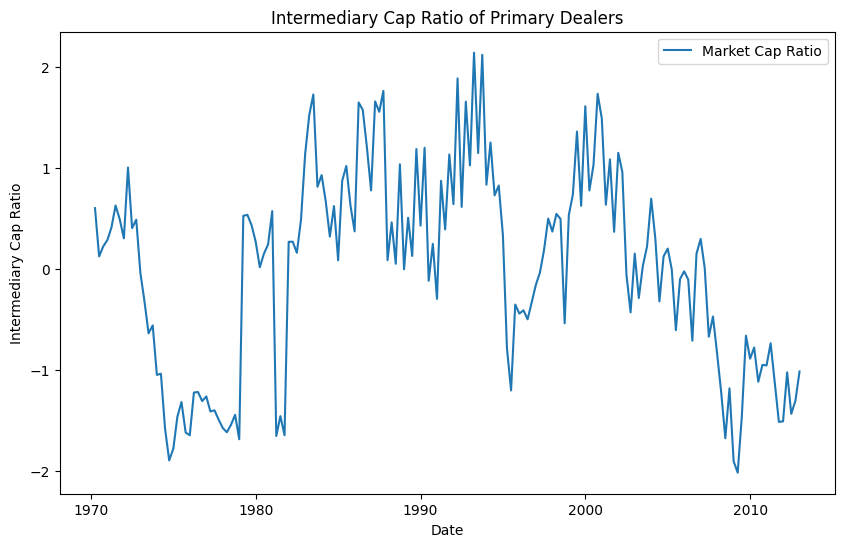

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(quarterly_sum_pd['datafqtr'], quarterly_sum_pd['market_cap_ratio_std'], label='Market Cap Ratio')

ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.set_xlabel('Date')
ax.set_ylabel('Intermediary Cap Ratio')
ax.set_title('Intermediary Cap Ratio of Primary Dealers')
ax.legend()
plt.show()

## 2. AEM Leverage
$$
\text{Leverage}_t = \frac{\text{Total Financial Assets}_t}{\text{Total Financial Assets}_t - \text{Total Liabilities}_t}
$$

$$
\text{Leverage Implied Capital Ratio} = \frac{1}{\text{Leverage}_t}
$$

### 1) First attempt - using the current pulled data 

In [45]:
# import load_fred and pull data from load_fred_macro_data
from load_fred import load_fred_macro_data
macro_data = load_fred_macro_data()

macro_data = macro_data.rename(columns={'UNRATE': 'unemp_rate', 
                                        'NFCI': 'nfci', 
                                        'GDP': 'nom_gdp', 
                                        'A191RL1Q225SBEA': 'real_gdp_growth',
                                        'BOGZ1FL664090005Q': 'bd_fin_assets',
                                        'BOGZ1FL664190005Q': 'bd_liabilities',
                                        })
macro_data

,unemp_rate,nfci,nom_gdp,real_gdp_growth,bd_fin_assets,bd_liabilities
DATE,,,,,,
1970-03-31,4.166667,NaN,1051.200,-0.6,13071.0,12089.0
1970-06-30,4.766667,NaN,1067.375,0.6,11741.0,10802.0
1970-09-30,5.166667,NaN,1086.059,3.7,13298.0,12384.0
1970-12-31,5.833333,NaN,1088.608,-4.2,16246.0,15340.0
1971-03-31,5.933333,0.893046,1135.156,11.3,14861.0,13923.0
...,...,...,...,...,...,...
2023-03-31,3.500000,-0.257849,26813.601,2.2,4803777.0,4501526.0
2023-06-30,3.566667,-0.231711,27063.012,2.1,4809159.0,4504411.0
2023-09-30,3.700000,-0.329422,27610.128,4.9,4757061.0,4449712.0


In [16]:
# calculate leverage 
# the AEM implied capital is the inverse of broker–dealer book leverage from Flow of Funds used in AEM
macro_data['aem_leverage'] = macro_data['bd_fin_assets'] / (macro_data['bd_fin_assets'] - macro_data['bd_liabilities'])
macro_data['aem_leverage_ratio'] = 1 / macro_data['aem_leverage'] 

macro_data

,unemp_rate,nfci,nom_gdp,GDPC1,bd_fin_assets,bd_liabilities,aem_leverage,aem_leverage_ratio
DATE,,,,,,,,
1970-03-31,4.166667,NaN,1051.200,5300.652,13071.0,12089.0,13.310591,0.075128
1970-06-30,4.766667,NaN,1067.375,5308.164,11741.0,10802.0,12.503727,0.079976
1970-09-30,5.166667,NaN,1086.059,5357.077,13298.0,12384.0,14.549234,0.068732
1970-12-31,5.833333,NaN,1088.608,5299.672,16246.0,15340.0,17.931567,0.055768
1971-03-31,5.933333,0.893046,1135.156,5443.619,14861.0,13923.0,15.843284,0.063118
...,...,...,...,...,...,...,...,...
2023-03-31,3.500000,-0.257849,26813.601,22112.329,4803777.0,4501526.0,15.893337,0.062919
2023-06-30,3.566667,-0.231711,27063.012,22225.350,4809159.0,4504411.0,15.780773,0.063368
2023-09-30,3.700000,-0.329422,27610.128,22490.692,4757061.0,4449712.0,15.477718,0.064609


In [17]:
# set the index as datetime
macro_data.index = pd.to_datetime(macro_data.index)
macro_data

,unemp_rate,nfci,nom_gdp,GDPC1,bd_fin_assets,bd_liabilities,aem_leverage,aem_leverage_ratio
DATE,,,,,,,,
1970-03-31,4.166667,NaN,1051.200,5300.652,13071.0,12089.0,13.310591,0.075128
1970-06-30,4.766667,NaN,1067.375,5308.164,11741.0,10802.0,12.503727,0.079976
1970-09-30,5.166667,NaN,1086.059,5357.077,13298.0,12384.0,14.549234,0.068732
1970-12-31,5.833333,NaN,1088.608,5299.672,16246.0,15340.0,17.931567,0.055768
1971-03-31,5.933333,0.893046,1135.156,5443.619,14861.0,13923.0,15.843284,0.063118
...,...,...,...,...,...,...,...,...
2023-03-31,3.500000,-0.257849,26813.601,22112.329,4803777.0,4501526.0,15.893337,0.062919
2023-06-30,3.566667,-0.231711,27063.012,22225.350,4809159.0,4504411.0,15.780773,0.063368
2023-09-30,3.700000,-0.329422,27610.128,22490.692,4757061.0,4449712.0,15.477718,0.064609


In [18]:
levels = quarterly_sum_pd[['datafqtr', 'market_cap_ratio', 'book_cap_ratio']].merge(macro_data[['aem_leverage']], left_on='datafqtr', right_index=True)
levels = levels.set_index('datafqtr')
levels

,market_cap_ratio,book_cap_ratio,aem_leverage
datafqtr,,,
1970-03-31,0.097045,0.054034,13.310591
1970-06-30,0.083692,0.055080,12.503727
1970-09-30,0.086464,0.054470,14.549234
1970-12-31,0.088236,0.075795,17.931567
1971-03-31,0.091724,0.068942,15.843284
...,...,...,...
2011-12-31,0.038039,0.058417,23.420368
2012-03-31,0.051598,0.060218,23.163604
2012-06-30,0.040132,0.058430,23.022625


### Results
- The correlation with the capital ratios are different.
- The graph of the AEM leverage ratio is slightly different from the paper's summary slides. 

In [19]:
# get the correlation of capital ratios 
correlation_panelA = levels.corr()
correlation_panelA

,market_cap_ratio,book_cap_ratio,aem_leverage
market_cap_ratio,1.000000,0.442542,0.137130
book_cap_ratio,0.442542,1.000000,-0.509959
aem_leverage,0.137130,-0.509959,1.000000


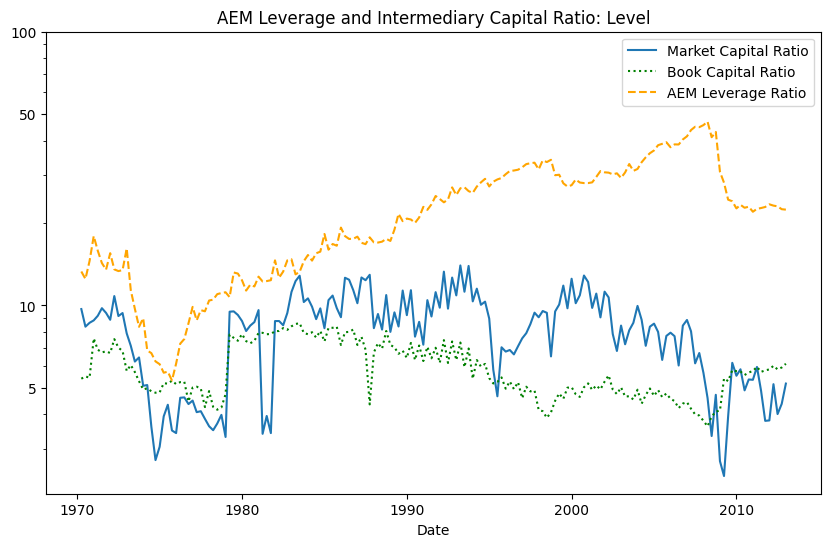

In [20]:
# plot the levels
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(levels.index, levels['market_cap_ratio']*100, label='Market Capital Ratio')
ax.plot(levels.index, levels['book_cap_ratio']*100, label='Book Capital Ratio', color='green', linestyle='dotted')
ax.plot(levels.index, levels['aem_leverage'], label='AEM Leverage Ratio', color='orange', linestyle='--')

ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.set_xlabel('Date')
ax.set_yscale('log')
ax.set_yticks([5, 10, 50, 100])
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter()) 

ax.set_title('AEM Leverage and Intermediary Capital Ratio: Level')
ax.legend(loc='best')
plt.show()


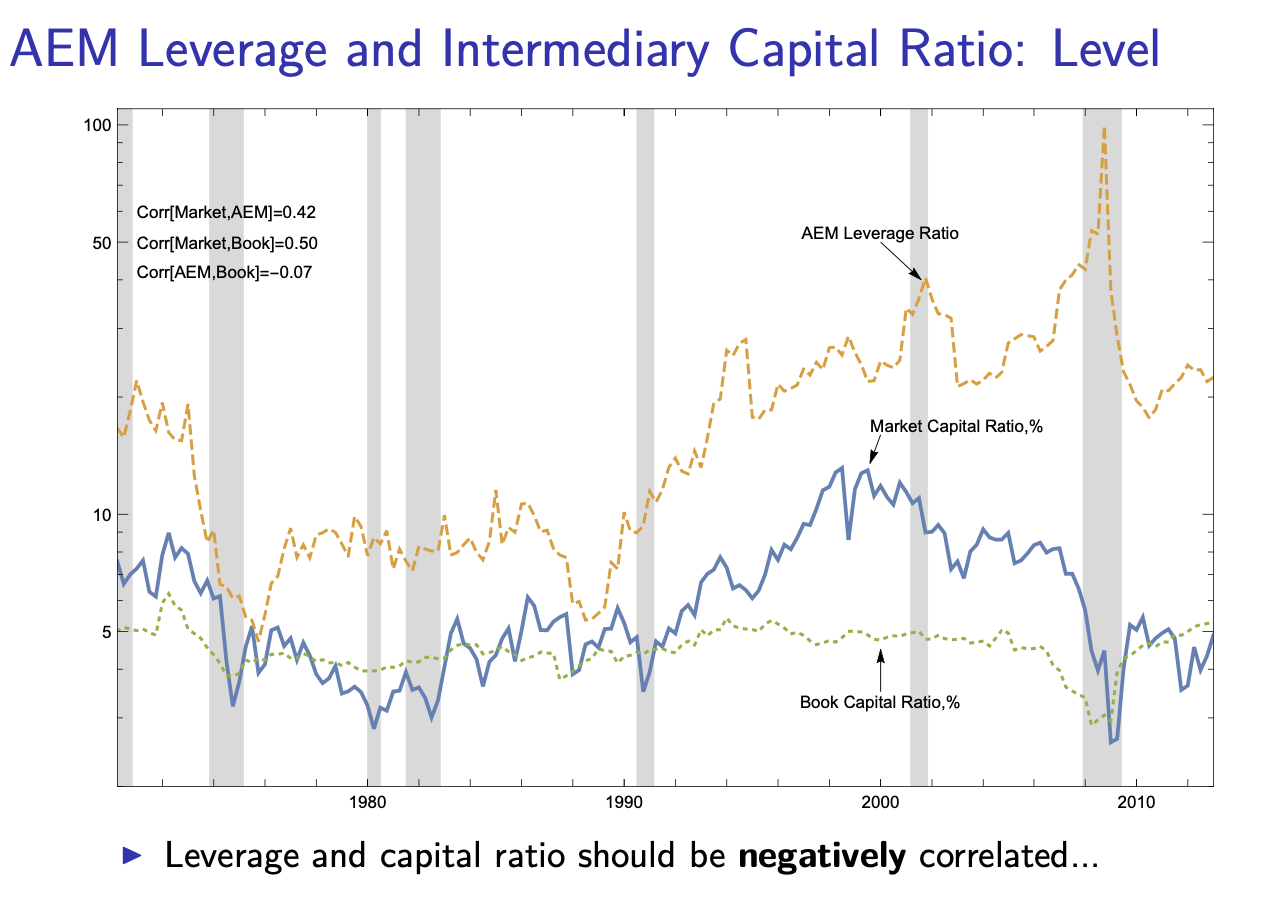

In [21]:
from IPython.display import Image
Image(filename='../data/AEM_level.png', width=800)

### 2) Second attempt - Fetch the historical data
- Total financial assets for the end of 2010.4Q, from the AEM paper, is 2,075.1 billion dollars.
- However, if we pull the current fred dataset, the same item for 2010.4Q is 4,312.8 billion dollars.
- Thus, here I used the past released dataset, which aligns with the AEM paper numbers. 
- link: https://www.federalreserve.gov/releases/z1/20130307/data.htm
    - L.127 Security Brokers and Dealers
    - ltabs.zip (1.3 MB ZIP): Outstandings--unadjusted(in millions of dollars)
- Howeverm the resulting plot is not very different from the first attempt.

In [22]:
fred_bd_data = pd.read_csv('fred_bd_aem.csv', index_col=0)
fred_bd_data.index = fred_bd_data.index.astype(str)
fred_bd_data.index = fred_bd_data.index.str[:4] + 'Q' + fred_bd_data.index.str[5] 

fred_bd_data = fred_bd_data.loc['1969Q4':'2012Q4']
fred_bd_data.index = fred_bd_data.index.to_series().apply(quarter_to_date)
fred_bd_data

,FL664090005.Q,FL663020003.Q,FL664004005.Q,FL663069103.Q,FL663061105.Q,FL663061703.Q,FL663062003.Q,FL663063005.Q,FL663069803.Q,FL663064003.Q,...,FL663170003.Q,FL663167005.Q,FL663167003.Q,FL763067005.Q,FL663178003.Q,FL663190005.Q,FL663192003.Q,FL663194005.Q,FL663193005.Q,Unnamed: 27
DATES,,,,,,,,,,,,,,,,,,,,,
1969-12-31,15402,1386,3670,0,1728,0,361,1581,0,1870,...,580,17200,5655,11545,147,653.0,196.00,0.00,457,NaN
1970-03-31,13071,1322,3436,0,2155,0,557,724,0,1015,...,590,14748,5098,9650,119,644.0,196.00,0.00,448,NaN
1970-06-30,11741,1225,2351,0,620,0,390,1341,0,1633,...,600,13221,4494,8727,108,632.0,194.00,0.00,438,NaN
1970-09-30,13298,1131,3850,0,2007,0,612,1231,0,1522,...,600,14813,4663,10150,135,629.0,192.00,0.00,437,NaN
1970-12-31,16246,1073,6003,0,3398,0,915,1690,0,1982,...,610,17689,4703,12986,150,596.0,169.00,0.00,427,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-31,1949702,111849,563194,42143,183559,147730,30899,104519,54344,103166,...,14262,1073702,752397,189601,131704,2533.0,473255.00,98123.00,1159268,-784136.0
2012-03-31,2063829,117367,610717,43707,203769,148650,34685,149291,30615,116254,...,17316,1107822,762286,190823,154713,2989.0,500165.00,100267.00,1347306,-947408.0
2012-06-30,2052880,105181,600456,34691,201167,169806,31167,130778,32847,113471,...,13480,1165747,777658,209770,178319,2846.0,463581.00,101097.00,1322272,-959788.0


In [23]:
macro_data_2 = pd.DataFrame()
macro_data_2['bd_fin_assets'] = fred_bd_data['FL664090005.Q']
macro_data_2['bd_liabilities'] = fred_bd_data['FL664190005.Q']
macro_data_2['aem_leverage'] =  macro_data_2['bd_fin_assets'] / (macro_data_2['bd_fin_assets'] - macro_data_2['bd_liabilities'])
macro_data_2

,bd_fin_assets,bd_liabilities,aem_leverage
DATES,,,
1969-12-31,15402,14553.00,18.141343
1970-03-31,13071,12285.00,16.629771
1970-06-30,11741,10996.00,15.759732
1970-09-30,13298,12576.00,18.418283
1970-12-31,16246,15509.00,22.043419
...,...,...,...
2011-12-31,1949702,1870911.00,24.745237
2012-03-31,2063829,1978049.00,24.059559
2012-06-30,2052880,1967675.00,24.093422


In [24]:
levels = quarterly_sum_pd[['datafqtr', 'market_cap_ratio', 'book_cap_ratio']].merge(macro_data_2[['aem_leverage']], left_on='datafqtr', right_index=True)
levels = levels.set_index('datafqtr')
levels

,market_cap_ratio,book_cap_ratio,aem_leverage
datafqtr,,,
1970-03-31,0.097045,0.054034,16.629771
1970-06-30,0.083692,0.055080,15.759732
1970-09-30,0.086464,0.054470,18.418283
1970-12-31,0.088236,0.075795,22.043419
1971-03-31,0.091724,0.068942,19.451571
...,...,...,...
2011-12-31,0.038039,0.058417,24.745237
2012-03-31,0.051598,0.060218,24.059559
2012-06-30,0.040132,0.058430,24.093422


In [25]:
# get the correlation of capital ratios 
correlation_panelA = levels.corr()
correlation_panelA

,market_cap_ratio,book_cap_ratio,aem_leverage
market_cap_ratio,1.000000,0.442542,-0.02991
book_cap_ratio,0.442542,1.000000,-0.59852
aem_leverage,-0.029910,-0.598520,1.00000


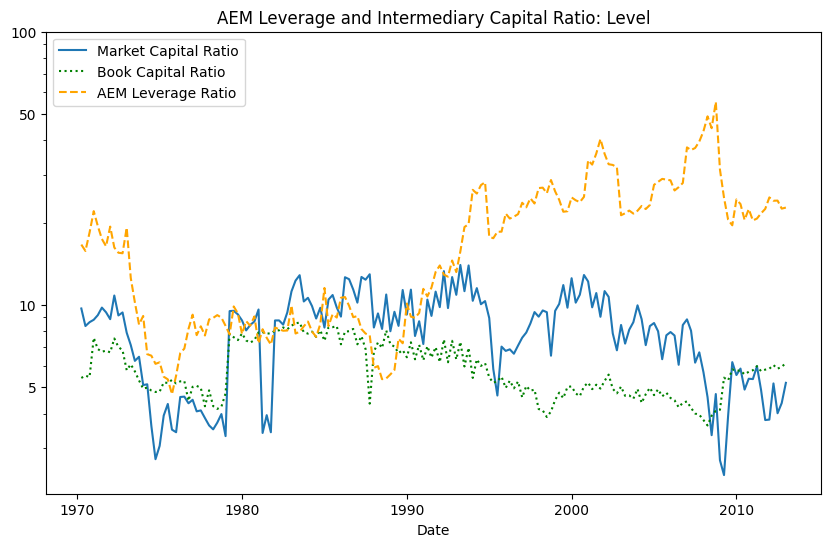

In [26]:
# plot the levels
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(levels.index, levels['market_cap_ratio']*100, label='Market Capital Ratio')
ax.plot(levels.index, levels['book_cap_ratio']*100, label='Book Capital Ratio', color='green', linestyle='dotted')
ax.plot(levels.index, levels['aem_leverage'], label='AEM Leverage Ratio', color='orange', linestyle='--')

ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.set_xlabel('Date')
ax.set_yscale('log')
ax.set_yticks([5, 10, 50, 100])
ax.get_yaxis().set_major_formatter(plt.ScalarFormatter()) 

ax.set_title('AEM Leverage and Intermediary Capital Ratio: Level')
ax.legend(loc='best')
plt.show()


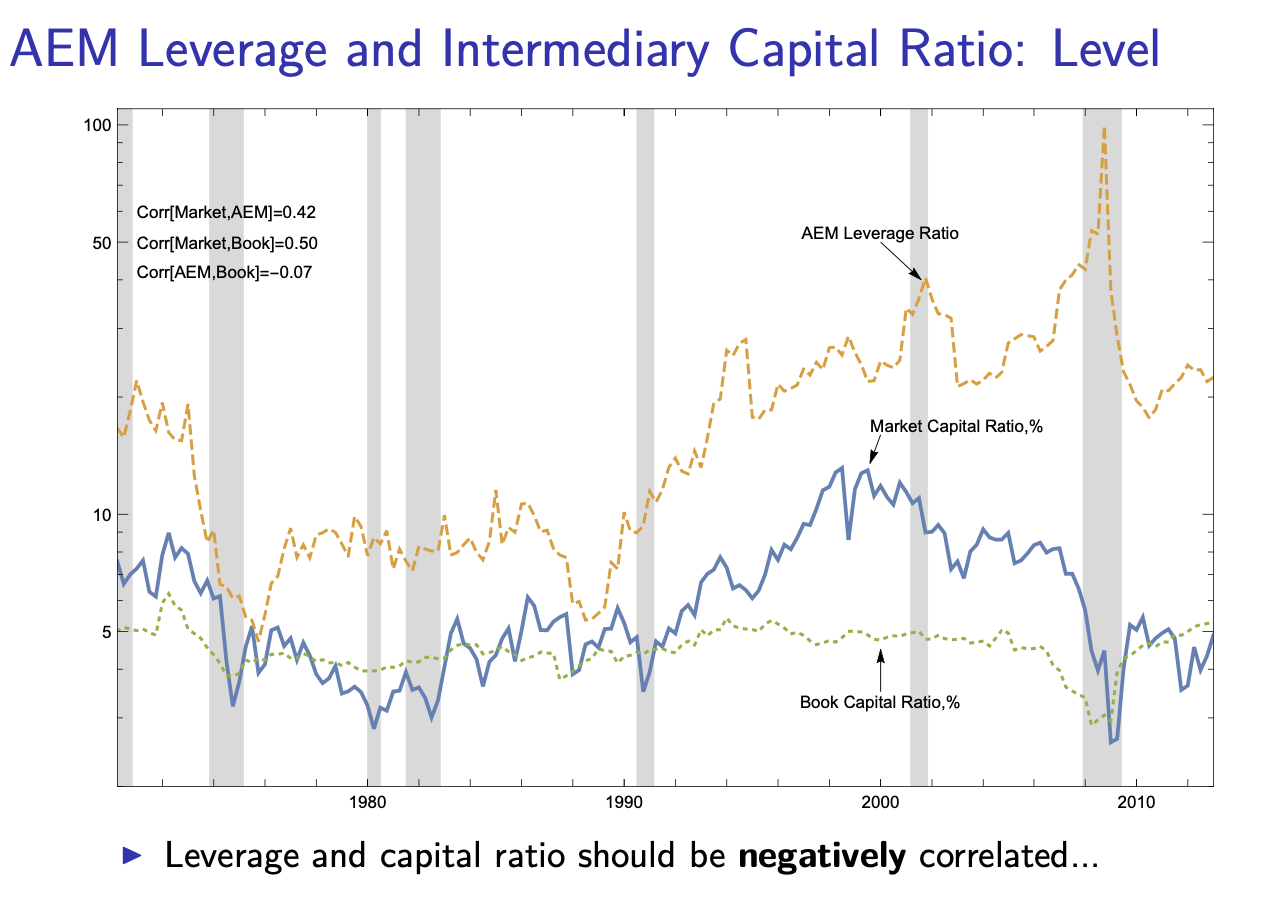

In [27]:
Image(filename='../data/AEM_level.png', width=800)

# Factors

In [28]:
from statsmodels.tsa.ar_model import AutoReg

In [29]:
# calculate the market capital factor, AR(1) innovations scaled by the lagged capital ratio 
cleaned_data = quarterly_sum_pd['market_cap_ratio'].dropna()
model = AutoReg(cleaned_data, lags=1)
model_fitted = model.fit()

quarterly_sum_pd['innovations_mkt_cap'] = model_fitted.resid
quarterly_sum_pd['market_capital_factor'] = quarterly_sum_pd['innovations_mkt_cap'] / quarterly_sum_pd['market_cap_ratio'].shift(1)
quarterly_sum_pd = quarterly_sum_pd.drop(columns=['innovations_mkt_cap'])

# standardize capital_risk_factor to zero mean and unit variance
quarterly_sum_pd['market_capital_factor_std'] = (quarterly_sum_pd['market_capital_factor'] - quarterly_sum_pd['market_capital_factor'].mean()) / quarterly_sum_pd['market_capital_factor'].std()

quarterly_sum_pd

/Users/youmjaehwa/anaconda3/envs/finm/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,datafqtr,total_assets,book_debt,book_equity,market_equity,market_cap_ratio,market_cap_ratio_std,book_cap_ratio,book_cap_ratio_std,market_capital_factor,market_capital_factor_std
32,1970-03-31,4.223853e+04,3.943661e+04,2252.638,4.238427e+03,0.097045,0.601940,0.054034,-0.380642,NaN,NaN
33,1970-06-30,4.207893e+04,3.924376e+04,2287.527,3.584361e+03,0.083692,0.124410,0.055080,-0.302075,-0.103146,-0.385518
34,1970-09-30,4.320479e+04,4.033412e+04,2323.551,3.817552e+03,0.086464,0.223569,0.054470,-0.347904,0.043600,0.185903
35,1970-12-31,4.435314e+04,4.145416e+04,3399.719,4.011740e+03,0.088236,0.286932,0.075795,1.254539,0.036550,0.158448
36,1971-03-31,4.584406e+04,4.287882e+04,3175.068,4.330199e+03,0.091724,0.411661,0.068942,0.739597,0.058973,0.245762
...,...,...,...,...,...,...,...,...,...,...,...
199,2011-12-31,2.262210e+07,2.121732e+07,1316360.323,8.390006e+05,0.038039,-1.508245,0.058417,-0.051265,-0.196409,-0.748678
200,2012-03-31,2.075195e+07,1.942295e+07,1244562.166,1.056701e+06,0.051598,-1.023356,0.060218,0.084053,0.157761,0.630435
201,2012-06-30,2.327922e+07,2.183596e+07,1355057.377,9.129659e+05,0.040132,-1.433385,0.058430,-0.050302,-0.320133,-1.230449
202,2012-09-30,2.326043e+07,2.179815e+07,1375772.056,9.968280e+05,0.043730,-1.304716,0.059367,0.020104,-0.089029,-0.330548


In [30]:
# calculate the book capital factor, AR(1) innovations scaled by the lagged capital ratio 
cleaned_data = quarterly_sum_pd['book_cap_ratio'].dropna()
model = AutoReg(cleaned_data, lags=1)
model_fitted = model.fit()

quarterly_sum_pd['innovations_book_cap'] = model_fitted.resid
quarterly_sum_pd['book_capital_factor'] = quarterly_sum_pd['innovations_book_cap'] / quarterly_sum_pd['book_cap_ratio'].shift(1)

# standardize capital_risk_factor to zero mean and unit variance
quarterly_sum_pd['book_capital_factor_std'] = (quarterly_sum_pd['book_capital_factor'] - quarterly_sum_pd['book_capital_factor'].mean()) / quarterly_sum_pd['book_capital_factor'].std()

quarterly_sum_pd

/Users/youmjaehwa/anaconda3/envs/finm/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,datafqtr,total_assets,book_debt,book_equity,market_equity,market_cap_ratio,market_cap_ratio_std,book_cap_ratio,book_cap_ratio_std,market_capital_factor,market_capital_factor_std,innovations_book_cap,book_capital_factor,book_capital_factor_std
32,1970-03-31,4.223853e+04,3.943661e+04,2252.638,4.238427e+03,0.097045,0.601940,0.054034,-0.380642,NaN,NaN,NaN,NaN,NaN
33,1970-06-30,4.207893e+04,3.924376e+04,2287.527,3.584361e+03,0.083692,0.124410,0.055080,-0.302075,-0.103146,-0.385518,0.000432,0.007997,0.074101
34,1970-09-30,4.320479e+04,4.033412e+04,2323.551,3.817552e+03,0.086464,0.223569,0.054470,-0.347904,0.043600,0.185903,-0.001105,-0.020065,-0.183335
35,1970-12-31,4.435314e+04,4.145416e+04,3399.719,4.011740e+03,0.088236,0.286932,0.075795,1.254539,0.036550,0.158448,0.020762,0.381157,3.497367
36,1971-03-31,4.584406e+04,4.287882e+04,3175.068,4.330199e+03,0.091724,0.411661,0.068942,0.739597,0.058973,0.245762,-0.005007,-0.066055,-0.605234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,2011-12-31,2.262210e+07,2.121732e+07,1316360.323,8.390006e+05,0.038039,-1.508245,0.058417,-0.051265,-0.196409,-0.748678,0.000288,0.004969,0.046318
200,2012-03-31,2.075195e+07,1.942295e+07,1244562.166,1.056701e+06,0.051598,-1.023356,0.060218,0.084053,0.157761,0.630435,0.001683,0.028807,0.265008
201,2012-06-30,2.327922e+07,2.183596e+07,1355057.377,9.129659e+05,0.040132,-1.433385,0.058430,-0.050302,-0.320133,-1.230449,-0.001702,-0.028271,-0.258618
202,2012-09-30,2.326043e+07,2.179815e+07,1375772.056,9.968280e+05,0.043730,-1.304716,0.059367,0.020104,-0.089029,-0.330548,0.000820,0.014041,0.129548


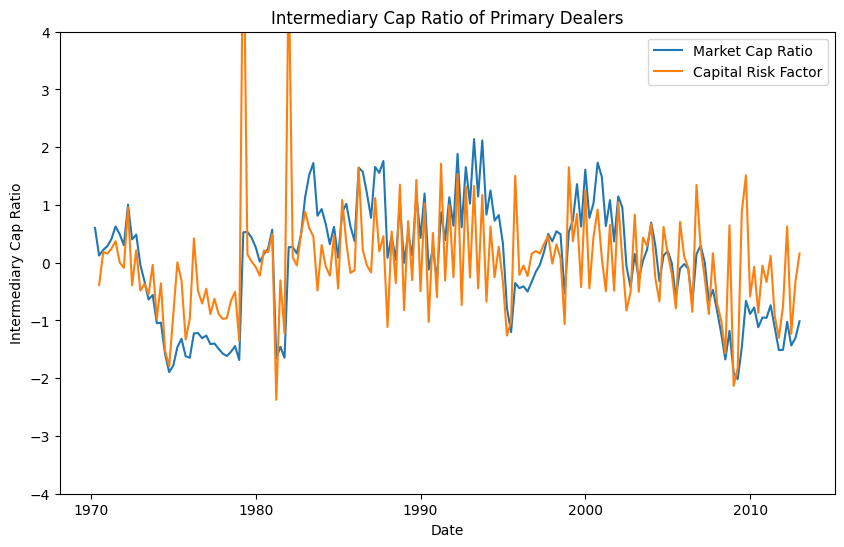

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(quarterly_sum_pd['datafqtr'], quarterly_sum_pd['market_cap_ratio_std'], label='Market Cap Ratio')
ax.plot(quarterly_sum_pd['datafqtr'], quarterly_sum_pd['market_capital_factor_std'], label='Capital Risk Factor')

ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.set_xlabel('Date')
ax.set_ylabel('Intermediary Cap Ratio')
ax.set_ylim(-4, 4)
ax.set_title('Intermediary Cap Ratio of Primary Dealers')
ax.legend()
plt.show()

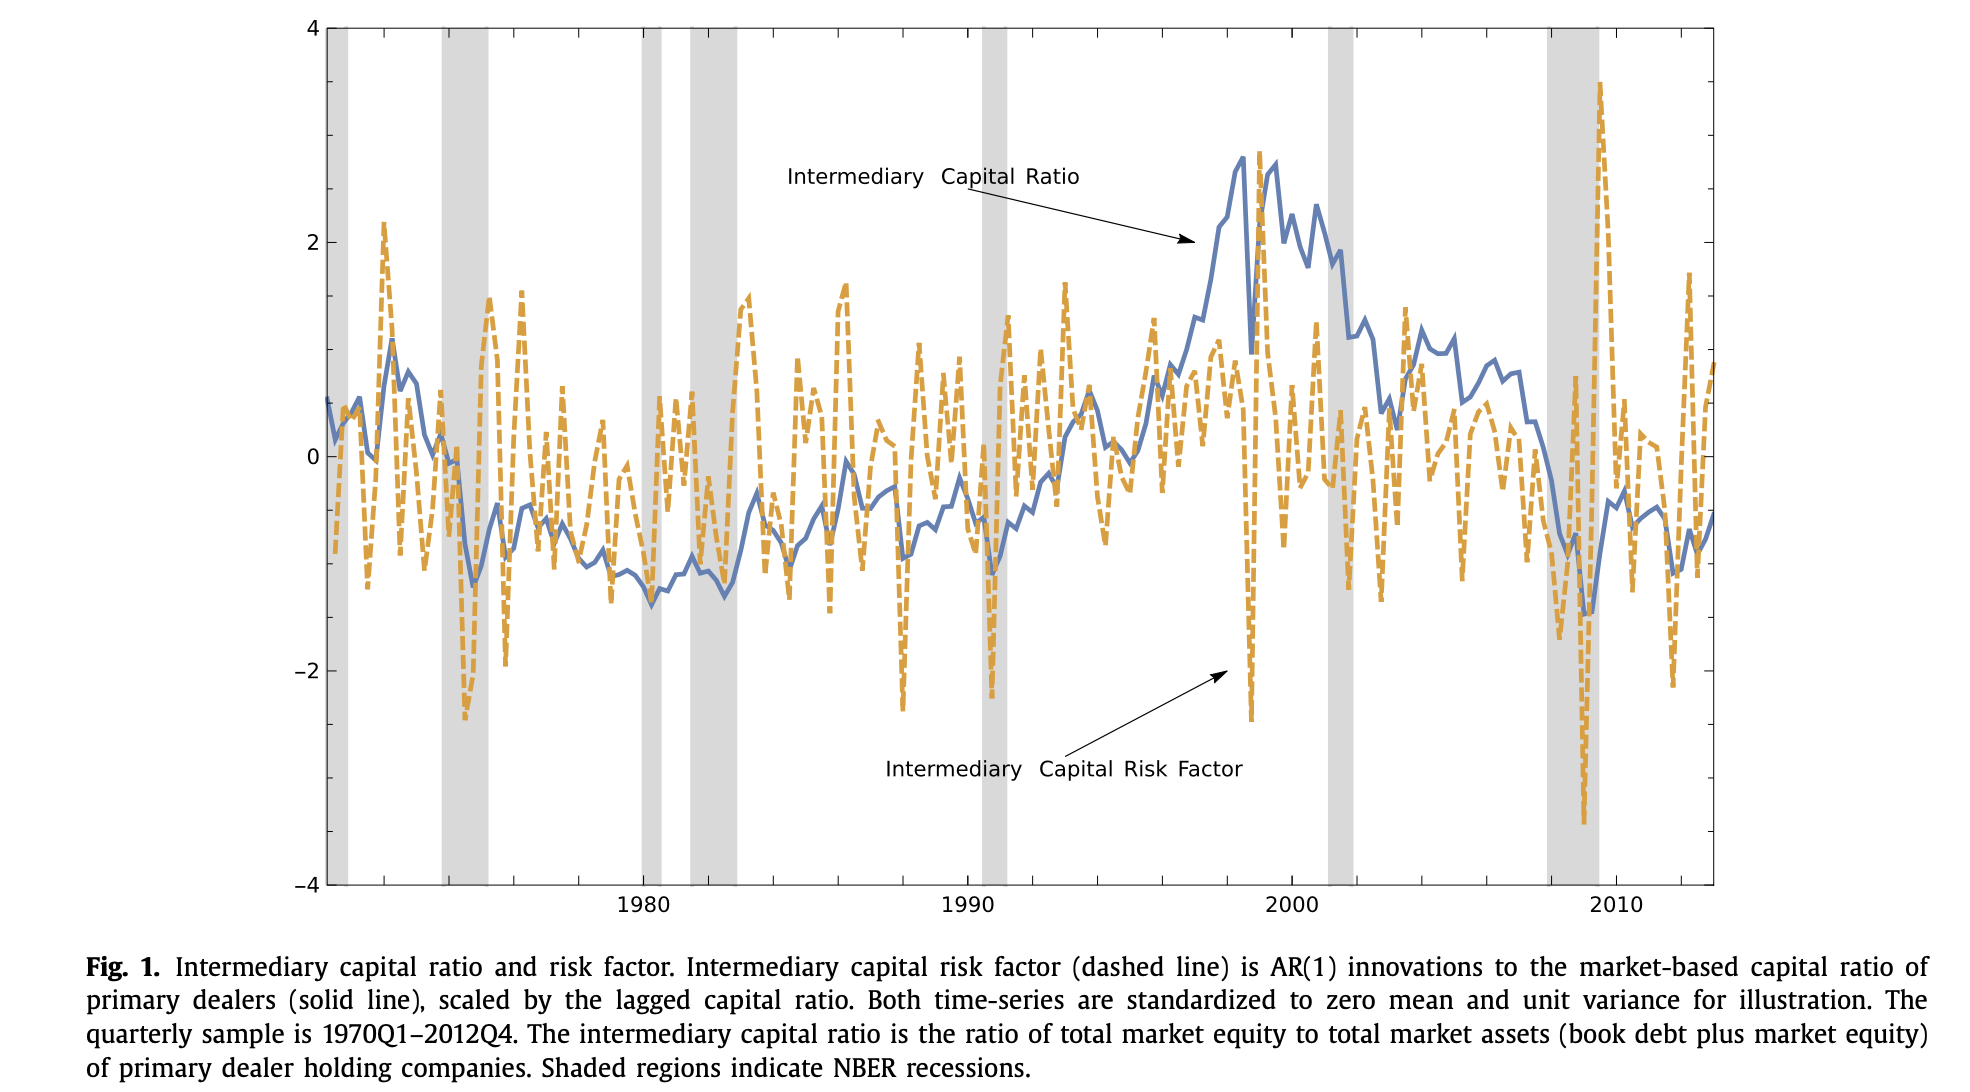

In [32]:
Image(filename='../data/Cap_ratio_factor.png', width=800)

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

# calculate the aem leverage factor, the seasonally adjusted growth rate in broker–dealer book leverage
macro_data['leverage_growth'] = macro_data['aem_leverage'].pct_change()
macro_data['leverage_growth'] = macro_data['leverage_growth'].fillna(0)

decomposition = seasonal_decompose(macro_data['leverage_growth'], model='additive')
macro_data['seasonal'] = decomposition.seasonal

macro_data['aem_leverage_factor'] = macro_data['leverage_growth'] - macro_data['seasonal']
macro_data

/var/folders/hk/t7fnwnf568g5fqkjmc9d2vbr0000gn/T/ipykernel_91664/3016275807.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  macro_data['leverage_growth'] = macro_data['aem_leverage'].pct_change()


,unemp_rate,nfci,nom_gdp,GDPC1,bd_fin_assets,bd_liabilities,aem_leverage,aem_leverage_ratio,leverage_growth,seasonal,aem_leverage_factor
DATE,,,,,,,,,,,
1970-03-31,4.166667,NaN,1051.200,5300.652,13071.0,12089.0,13.310591,0.075128,0.000000,-0.018409,0.018409
1970-06-30,4.766667,NaN,1067.375,5308.164,11741.0,10802.0,12.503727,0.079976,-0.060618,0.003537,-0.064156
1970-09-30,5.166667,NaN,1086.059,5357.077,13298.0,12384.0,14.549234,0.068732,0.163592,0.002683,0.160908
1970-12-31,5.833333,NaN,1088.608,5299.672,16246.0,15340.0,17.931567,0.055768,0.232475,0.012188,0.220287
1971-03-31,5.933333,0.893046,1135.156,5443.619,14861.0,13923.0,15.843284,0.063118,-0.116459,-0.018409,-0.098050
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,3.500000,-0.257849,26813.601,22112.329,4803777.0,4501526.0,15.893337,0.062919,0.054408,-0.018409,0.072816
2023-06-30,3.566667,-0.231711,27063.012,22225.350,4809159.0,4504411.0,15.780773,0.063368,-0.007082,0.003537,-0.010620
2023-09-30,3.700000,-0.329422,27610.128,22490.692,4757061.0,4449712.0,15.477718,0.064609,-0.019204,0.002683,-0.021887


In [34]:
factors = quarterly_sum_pd[['datafqtr', 'market_capital_factor', 'book_capital_factor']].merge(macro_data[['aem_leverage_factor']], left_on='datafqtr', right_index=True)
factors = factors.set_index('datafqtr')
factors

,market_capital_factor,book_capital_factor,aem_leverage_factor
datafqtr,,,
1970-03-31,NaN,NaN,0.018409
1970-06-30,-0.103146,0.007997,-0.064156
1970-09-30,0.043600,-0.020065,0.160908
1970-12-31,0.036550,0.381157,0.220287
1971-03-31,0.058973,-0.066055,-0.098050
...,...,...,...
2011-12-31,-0.196409,0.004969,0.010458
2012-03-31,0.157761,0.028807,0.007445
2012-06-30,-0.320133,-0.028271,-0.009624


In [35]:
# get the correlation of factors
correlation_panelB = factors.corr()
correlation_panelB

,market_capital_factor,book_capital_factor,aem_leverage_factor
market_capital_factor,1.000000,0.450022,0.102914
book_capital_factor,0.450022,1.000000,-0.028537
aem_leverage_factor,0.102914,-0.028537,1.000000


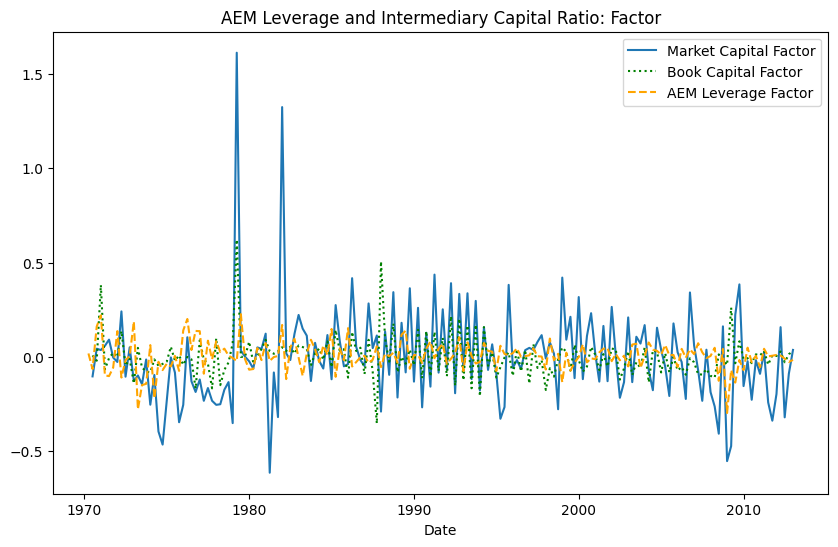

In [36]:
# plot the factors
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(factors.index, factors['market_capital_factor'], label='Market Capital Factor')
ax.plot(factors.index, factors['book_capital_factor'], label='Book Capital Factor', color='green', linestyle='dotted')
ax.plot(factors.index, factors['aem_leverage_factor'], label='AEM Leverage Factor', color='orange', linestyle='--')

ax.xaxis.set_major_locator(mdates.YearLocator(10))
ax.set_xlabel('Date')

ax.set_title('AEM Leverage and Intermediary Capital Ratio: Factor')
ax.legend(loc='best')
plt.show()


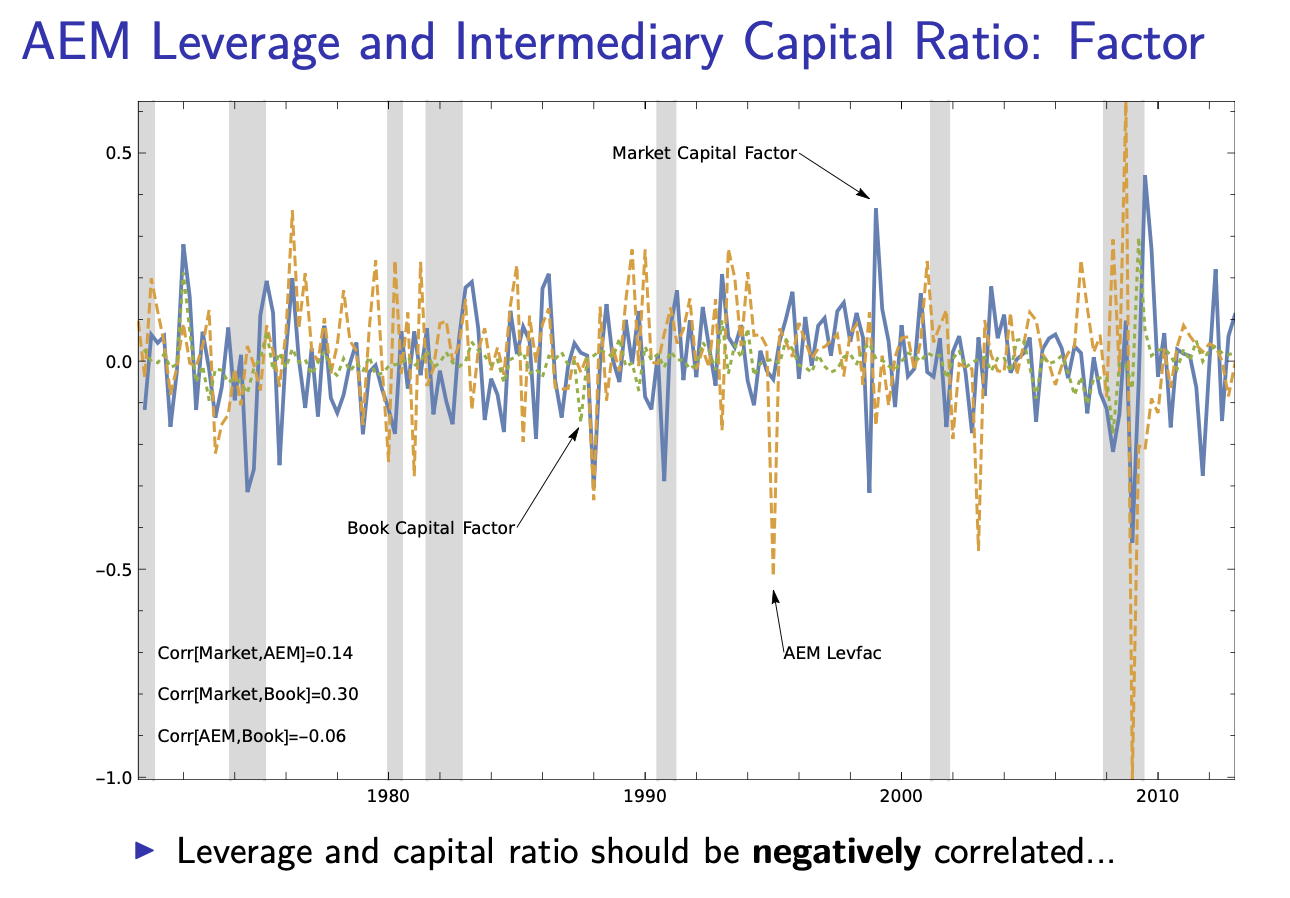

In [37]:
Image(filename='../data/AEM_factor.png', width=800)

----
# Macro Variables
## 1. E/P

In [38]:
# query = """
#         SELECT a.datadate, a.req, a.datafqtr, b.gvkey, b.iid , b.from, b.thru
#         FROM
#             comp.fundq a
#         INNER JOIN
#             comp.idxcst_his b ON a.gvkey = b.gvkey
#         WHERE
#             a.DATAFMT = 'STD' AND
#             a.INDFMT = 'INDL' AND
#             a.CONSOL = 'C' AND
#             a.POPSRC = 'D' AND
#             a.datadate >= b.from AND
#             (a.datadate <= b.thru OR b.thru IS NULL)
#         ORDER BY a.datadate;
#         """

# sp500_earnings = db.raw_sql(query)
# sp500_earnings

In [39]:
# use the data from the excel file
shiller_cape = pd.read_excel('Shiller_CAPE.xls', skiprows=9, usecols="A,M")
shiller_cape.columns = ['date', 'cape']

shiller_cape['date'] = shiller_cape['date'].astype(str)
shiller_cape['date'] = pd.to_datetime(shiller_cape['date'], format='%Y.%m') + pd.offsets.MonthEnd(0)

shiller_cape = shiller_cape[(shiller_cape['date'] >= '1970-01-01') & (shiller_cape['date'] <= '2012-12-31')]
shiller_cape = shiller_cape.set_index('date')

shiller_cape['e/p'] = 1 / shiller_cape['cape']
shiller_cape

,cape,e/p
date,,
1970-01-31,17.090541,0.058512
1970-02-28,16.372587,0.061078
1970-03-31,16.531691,0.060490
1970-04-30,15.873068,0.063000
1970-05-31,13.983836,0.071511
...,...,...
2012-08-31,21.410428,0.046706
2012-09-30,21.783690,0.045906
2012-01-31,21.577110,0.046345


## 2. Unemployment, GDP, Financial Conditions

In [40]:
macro_data

,unemp_rate,nfci,nom_gdp,GDPC1,bd_fin_assets,bd_liabilities,aem_leverage,aem_leverage_ratio,leverage_growth,seasonal,aem_leverage_factor
DATE,,,,,,,,,,,
1970-03-31,4.166667,NaN,1051.200,5300.652,13071.0,12089.0,13.310591,0.075128,0.000000,-0.018409,0.018409
1970-06-30,4.766667,NaN,1067.375,5308.164,11741.0,10802.0,12.503727,0.079976,-0.060618,0.003537,-0.064156
1970-09-30,5.166667,NaN,1086.059,5357.077,13298.0,12384.0,14.549234,0.068732,0.163592,0.002683,0.160908
1970-12-31,5.833333,NaN,1088.608,5299.672,16246.0,15340.0,17.931567,0.055768,0.232475,0.012188,0.220287
1971-03-31,5.933333,0.893046,1135.156,5443.619,14861.0,13923.0,15.843284,0.063118,-0.116459,-0.018409,-0.098050
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31,3.500000,-0.257849,26813.601,22112.329,4803777.0,4501526.0,15.893337,0.062919,0.054408,-0.018409,0.072816
2023-06-30,3.566667,-0.231711,27063.012,22225.350,4809159.0,4504411.0,15.780773,0.063368,-0.007082,0.003537,-0.010620
2023-09-30,3.700000,-0.329422,27610.128,22490.692,4757061.0,4449712.0,15.477718,0.064609,-0.019204,0.002683,-0.021887


## 3. Market volatility

In [41]:
def pull_CRSP_Value_Weighted_Index():
    """
    Pulls a value-weighted stock index from the CRSP database.

    Returns:
    - pandas.DataFrame: DataFrame containing the value-weighted stock index data.

    Note:
    This function executes a SQL query to retrieve the value-weighted stock index data from CRSP. 
    The returned DataFrame includes columns for 'date' and 'vwretd' (value-weighted return including dividends).
    """
    
    sql_query = """
        SELECT date, vwretd
        FROM crsp.msi as msi
        WHERE msi.date >= '1970-01-01' AND msi.date <= '2012-12-31'
        """
    
    data = db.raw_sql(sql_query, date_cols=["date"])
    return data

In [48]:
value_wtd_indx = pull_CRSP_Value_Weighted_Index()

value_wtd_indx['date'] = pd.to_datetime(value_wtd_indx['date'])
value_wtd_indx.set_index('date', inplace=True)

value_wtd_indx['change'] = value_wtd_indx['vwretd'].pct_change()
volatility_by_quarter = value_wtd_indx['change'].groupby(pd.Grouper(freq='Q')).std()
annualized_volatility = volatility_by_quarter.rename('mkt_vol')
annualized_volatility

date
1970-03-31     0.488403
1970-06-30    12.452839
1970-09-30     1.314768
1970-12-31     2.000585
1971-03-31     1.216783
                ...    
2011-12-31     0.647398
2012-03-31     8.110201
2012-06-30     5.797123
2012-09-30     1.165194
2012-12-31     1.448625
Freq: Q-DEC, Name: mkt_vol, Length: 172, dtype: float64

In [49]:
levels2 = levels.merge(macro_data[['unemp_rate', 'nfci', 'real_gdp_growth']], left_index=True, right_index=True)
levels2 = levels2.merge(shiller_cape[['e/p']], left_index=True, right_index=True)
levels2 = levels2.merge(annualized_volatility, left_index=True, right_index=True)
levels2

,market_cap_ratio,book_cap_ratio,aem_leverage,unemp_rate,nfci,real_gdp_growth,e/p,mkt_vol
1970-03-31,0.097045,0.054034,16.629771,4.166667,NaN,-0.6,0.060490,0.488403
1970-06-30,0.083692,0.055080,15.759732,4.766667,NaN,0.6,0.072465,12.452839
1970-09-30,0.086464,0.054470,18.418283,5.166667,NaN,3.7,0.067373,1.314768
1970-12-31,0.088236,0.075795,22.043419,5.833333,NaN,-4.2,0.062997,2.000585
1971-03-31,0.091724,0.068942,19.451571,5.933333,0.893046,11.3,0.057462,1.216783
...,...,...,...,...,...,...,...,...
2011-12-31,0.038039,0.058417,24.745237,8.633333,-0.037752,4.6,0.048724,0.647398
2012-03-31,0.051598,0.060218,24.059559,8.266667,-0.342423,3.4,0.045343,8.110201
2012-06-30,0.040132,0.058430,24.093422,8.200000,-0.298828,1.8,0.048668,5.797123
2012-09-30,0.043730,0.059367,22.513054,8.033333,-0.399551,0.6,0.045906,1.165194


# Final Output

In [50]:
main_cols = levels2[['market_cap_ratio', 'book_cap_ratio', 'aem_leverage']]
other_cols = levels2[['e/p', 'unemp_rate', 'real_gdp_growth', 'nfci',  'mkt_vol']]

correlation_results = pd.DataFrame(index=main_cols.columns)

for column in other_cols.columns:
    correlation_results[column] = main_cols.corrwith(other_cols[column])

correlation_results.T

,market_cap_ratio,book_cap_ratio,aem_leverage
e/p,-0.206516,0.564069,-0.714248
unemp_rate,-0.187025,0.472442,-0.371841
real_gdp_growth,0.157368,0.030433,-0.124858
nfci,-0.258296,0.303530,-0.343886
mkt_vol,-0.042367,0.063976,-0.126646
